<a href="https://colab.research.google.com/github/lijingwang/hbvpy/blob/main/HBV_sensitivity_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/lijingwang/hbvpy.git
%cd hbvpy

In [ ]:
!pip install SALib pyDGSA -q

# Sensitivity Analysis of the HBV Model

This notebook demonstrates four sensitivity analysis methods applied to the HBV hydrological model:

1. **One-at-a-Time (OAT) Local SA**: Perturbation-based local sensitivity around a baseline
2. **Morris Method**: Global screening using elementary effects
3. **Sobol Method**: Variance-based global sensitivity analysis (first-order, second-order, and total-order)
4. **DGSA**: Distance-based Global Sensitivity Analysis (main effects + interactions)

We evaluate sensitivity using **three response metrics** to capture different flow regimes:

| Metric | Description | Flow Regime |
|--------|-------------|-------------|
| Mean Q | Mean discharge | Overall water balance |
| Q10 | Flow exceeded 10% of the time | High flow |
| Q90 | Flow exceeded 90% of the time | Low flow |

| Method | Type | Strengths | Cost |
|--------|------|-----------|------|
| OAT | Local | Simple, interpretable | Low (~2d+1 runs) |
| Morris | Global screening | Identifies important vs unimportant | Moderate (~N(d+1) runs) |
| Sobol | Global, variance-based | Quantifies main, pairwise & total interactions | High (~N(2d+2) runs) |
| DGSA | Global, distribution-based | Non-parametric, multivariate responses, interactions | Moderate (~1000 runs) |

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import qmc
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = 'retina'

from hbv import hbv_run

## 1. Load Data & Define Parameters

In [2]:
example_dir = Path("examples") / "Prof_Amir_AghaKouchak_example"

forcing = pd.read_csv(example_dir / "inputPrecipTemp.csv", parse_dates=["Time"])
forcing["Time"] = pd.to_datetime(forcing["Time"], format="%Y-%m-%d")
pet = pd.read_csv(example_dir / "inputMonthlyTempEvap.csv")
Qobs = pd.read_csv(example_dir / "Qobs.csv", parse_dates=["Time"])
Qobs["Time"] = pd.to_datetime(Qobs["Time"], format="%Y-%m-%d")

param_names = ["d", "fc", "beta", "cpar", "k0", "lthr", "k1", "k2", "kp", "pwp"]

param_bounds = {
    "d":    (1.0, 5.0), # if you work with your own site, you probably want to update these prior distributions :) 
    "fc":   (100.0, 400.0),
    "beta": (1.0, 5.0),
    "cpar": (0.01, 0.3),
    "k0":   (0.1, 0.5),
    "lthr": (1.0, 20.0),
    "k1":   (0.01, 0.2),
    "k2":   (0.005, 0.15),
    "kp":   (0.01, 0.15),
    "pwp":  (50.0, 200.0),
}

lower_bounds = np.array([param_bounds[p][0] for p in param_names])
upper_bounds = np.array([param_bounds[p][1] for p in param_names])
n_params = len(param_names)

print(f"Simulation period: {forcing['Time'].min()} to {forcing['Time'].max()}")
print(f"Number of days: {len(forcing)}")
print(f"Number of parameters: {n_params}")

Simulation period: 1991-01-01 00:00:00 to 2000-12-30 00:00:00
Number of days: 3652
Number of parameters: 10


In [3]:
WARMUP = 365  # skip first year

def hbv_run_ts(params):
    """Run HBV model and return the full discharge time series."""
    results, _ = hbv_run(
        forcing=forcing, pet_monthly=pet, params=params,
        area_km2=410.0, Tsnow_thresh=0.0,
        init_state={"snow": 0.0, "soil": 0.0, "s1": 0.0, "s2": 0.0},
    )
    return results["Q_m3s"].values

def hbv_metrics(params):
    """Run HBV and return dict of {mean_Q, Q10, Q90} after warmup.
    Q10/Q90 use the exceedance probability convention:
      Q10 = flow exceeded 10% of the time (high flow)
      Q90 = flow exceeded 90% of the time (low flow)
    """
    Q = hbv_run_ts(params)[WARMUP:]
    return {
        "mean_Q": np.mean(Q),
        "Q10":    np.percentile(Q, 90),   # exceeded 10% of time = high flow
        "Q90":    np.percentile(Q, 10),   # exceeded 90% of time = low flow
    }

metric_labels = {"mean_Q": "Mean Q", "Q10": "Q10 (High Flow)", "Q90": "Q90 (Low Flow)"}

# Baseline
baseline_params = (upper_bounds-lower_bounds)*0.5 + lower_bounds
baseline_metrics = hbv_metrics(baseline_params)
print(f"Baseline: {baseline_metrics}")

Baseline: {'mean_Q': np.float64(6.094950157529455), 'Q10': np.float64(13.682092877050037), 'Q90': np.float64(0.5194758346076347)}


## 2. One-at-a-Time (OAT) Local Sensitivity Analysis

OAT perturbs each parameter individually around a baseline while keeping all others fixed.
We compute the **elasticity** $E_i = (\partial Y / Y) \cdot (p_i / \partial p_i)$ for three metrics:
Mean Q, Q10 (high flow), and Q90 (low flow).

**Limitation**: OAT only captures local behavior and ignores parameter interactions.

In [4]:
delta_frac = 0.05
metrics_list = ["mean_Q", "Q10", "Q90"]
oat_elasticities = {m: np.zeros(n_params) for m in metrics_list}

for i in range(n_params):
    delta = delta_frac * (upper_bounds[i] - lower_bounds[i])

    params_plus = baseline_params.copy()
    params_plus[i] += delta
    m_plus = hbv_metrics(params_plus)

    params_minus = baseline_params.copy()
    params_minus[i] -= delta
    m_minus = hbv_metrics(params_minus)

    for m in metrics_list:
        sens = (m_plus[m] - m_minus[m]) / (2 * delta)
        oat_elasticities[m][i] = sens * baseline_params[i] / baseline_metrics[m]

print(f"OAT: {2*n_params + 1} model evaluations (1 baseline + 2x{n_params} perturbations)")

OAT: 21 model evaluations (1 baseline + 2x10 perturbations)


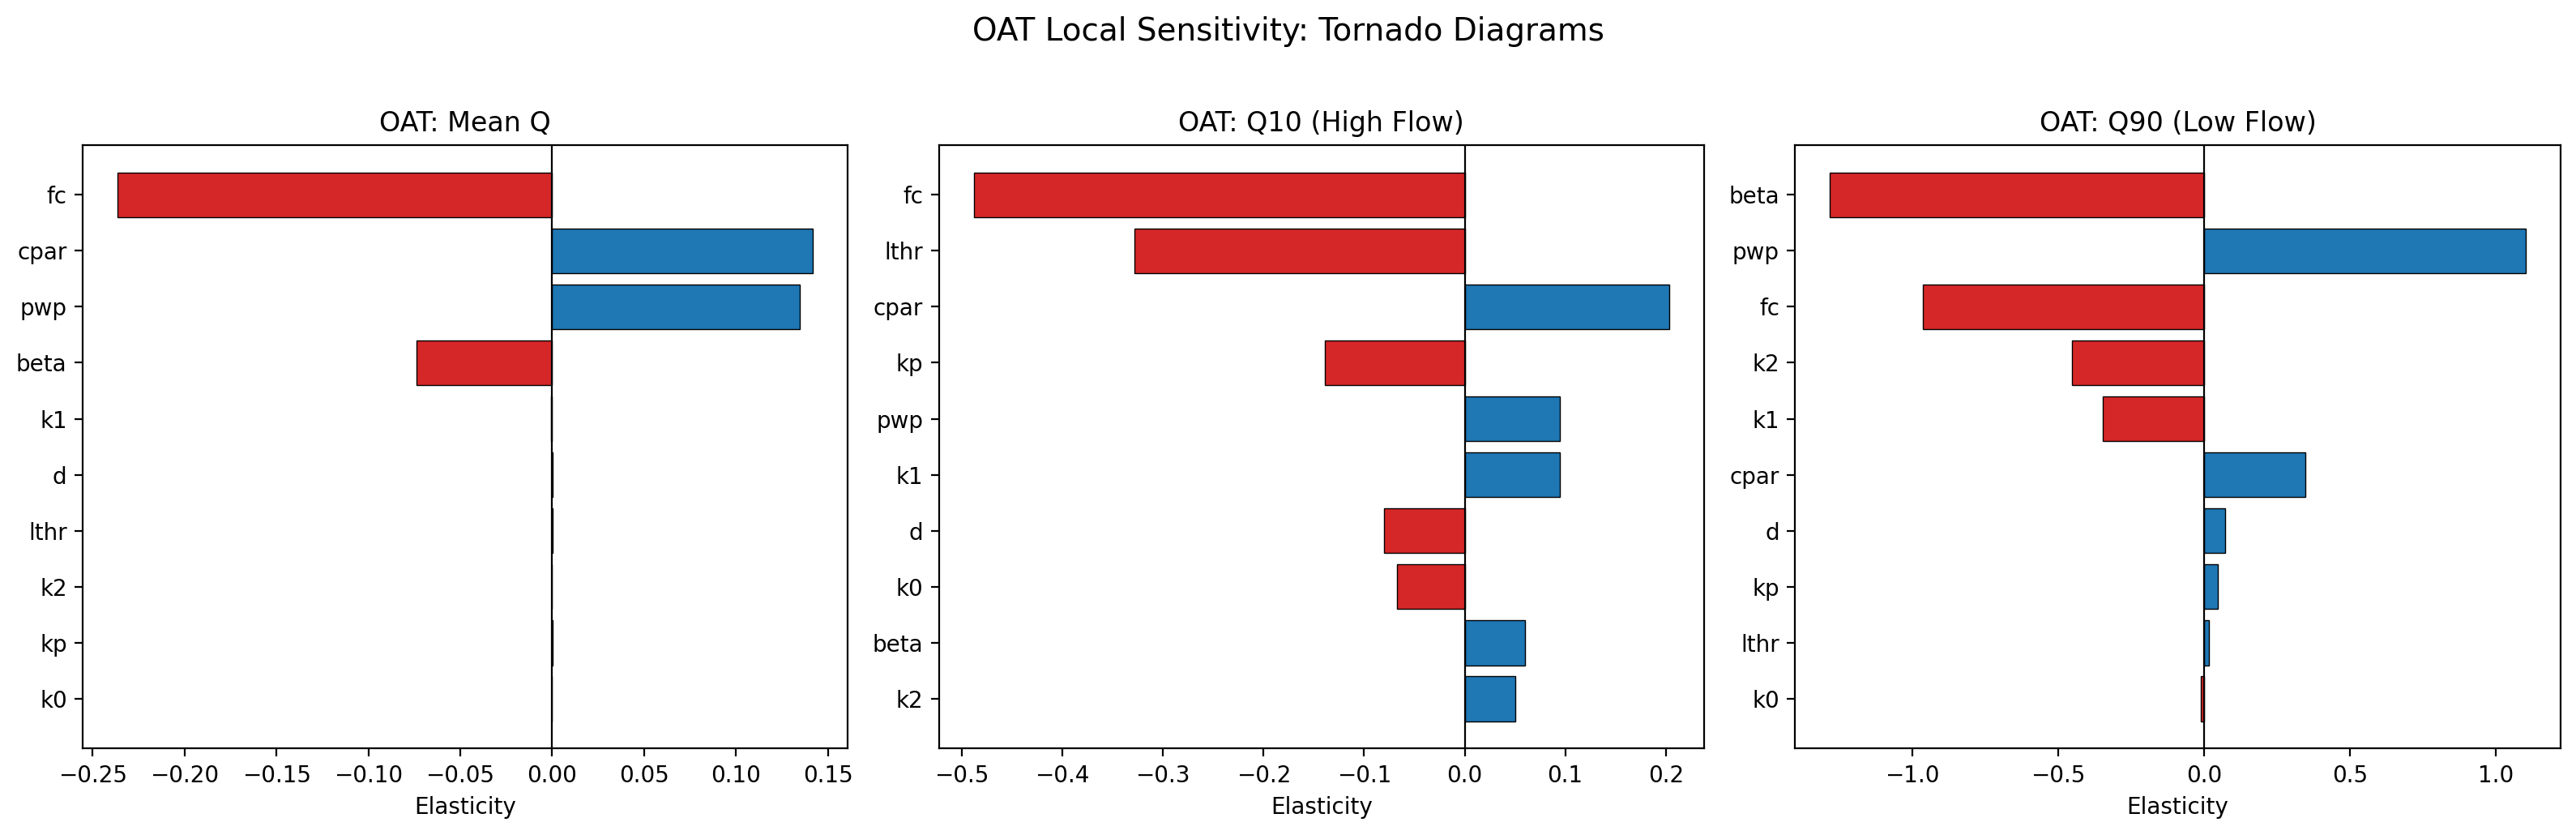

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=False)

for ax, m in zip(axes, metrics_list):
    sorted_idx = np.argsort(np.abs(oat_elasticities[m]))[::-1]  # rank 1 at top
    sorted_names = [param_names[i] for i in sorted_idx]
    sorted_elast = oat_elasticities[m][sorted_idx]
    colors = ["C0" if e >= 0 else "C3" for e in sorted_elast]
    y_pos = np.arange(n_params, 0, -1)  # top-down: rank 1 at top
    ax.barh(y_pos, sorted_elast, color=colors, edgecolor="k", linewidth=0.5)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(sorted_names)
    ax.set_xlabel("Elasticity")
    ax.set_title(f"OAT: {metric_labels[m]}")
    ax.axvline(x=0, color="k", linewidth=0.8)

plt.suptitle("OAT Local Sensitivity: Tornado Diagrams", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 3. Morris Method (Elementary Effects)

The Morris method (Morris, 1991) is a global screening method that identifies:
- **$\mu^*$** (mean of absolute elementary effects): Overall parameter importance
- **$\sigma$** (std of elementary effects): Degree of non-linearity or interaction

### How Morris Sampling Works

The parameter space is discretized into a grid, and each **trajectory** is a random walk
that changes one parameter at a time.

**Key parameters:**

- **`N` (number of trajectories)**: Each trajectory starts at a random grid point and
  takes `d` steps (one per parameter), yielding `d+1` points. Total model evaluations =
  `N × (d+1)`. More trajectories → more stable $\mu^*$ and $\sigma$ estimates.
- **`num_levels` (grid resolution)**: Each parameter range is divided into this many
  equally-spaced levels. Higher values give a finer grid; **4 is the standard choice**.

**The grid and step size ($\Delta$):**

Everything operates in **normalized [0, 1] space**. With `num_levels=4`, the grid is
`{0, 1/3, 2/3, 1}` and the step size is:

$$\Delta = \frac{p}{2(p-1)} = \frac{4}{2 \times 3} = \frac{2}{3}$$

This specific $\Delta$ guarantees that stepping $\pm\Delta$ from any grid point always
lands on another valid grid point (e.g., $0 + 2/3 = 2/3$, $1/3 + 2/3 = 1$).

**Handling different parameter ranges:**

Since $\Delta$ is in normalized space, the actual perturbation **scales with each
parameter's range** automatically:

$$\text{actual step}_i = \Delta \times (\text{upper}_i - \text{lower}_i)$$

| Parameter | Range | Actual step ($\Delta \times$ range) |
|-----------|-------|--------------------------------------|
| d | [1, 5] → 4 | 2/3 × 4 = **2.67** mm/°C/day |
| fc | [100, 400] → 300 | 2/3 × 300 = **200** mm |
| cpar | [0.01, 0.3] → 0.29 | 2/3 × 0.29 = **0.193** |
| k2 | [0.005, 0.15] → 0.145 | 2/3 × 0.145 = **0.097** 1/day |

The elementary effect $EE_i = (Y_{\text{after}} - Y_{\text{before}}) / \Delta_{\text{normalized}}$
measures how much the output changes when a parameter moves **2/3 of its plausible range**,
making EEs comparable across parameters despite different physical units.

**Example trajectory** (d=10 params, each step changes one param by $\pm\Delta$):

```
Step 0:  Start at random grid point → point 1
Step 1:  Perturb param "d" by +Δ   → point 2  → EE for "d"
Step 2:  Perturb param "fc" by +Δ  → point 3  → EE for "fc"
...  
Step 10: Perturb param "pwp" by -Δ → point 11 → EE for "pwp"
```

With `N=100` trajectories × 11 points each = **1,100 model evaluations**,
giving 100 elementary effects per parameter. Then:
- $\mu^*$ = mean of $|EE|$ across trajectories (importance)
- $\sigma$ = std of $EE$ across trajectories (non-linearity / interactions)

We run Morris for all three metrics (Mean Q, Q10, Q90).

In [6]:
from SALib.sample.morris import sample as morris_sample
from SALib.analyze.morris import analyze as morris_analyze

problem = {
    'num_vars': n_params,
    'names': param_names,
    'bounds': [[lower_bounds[i], upper_bounds[i]] for i in range(n_params)]
}

X_morris = morris_sample(problem, N=100, num_levels=4, seed=42)
print(f"Morris samples: {X_morris.shape[0]} model evaluations")

# Run model and collect all three metrics
Y_morris = {m: np.zeros(X_morris.shape[0]) for m in metrics_list}

for i in range(X_morris.shape[0]):
    Q = hbv_run_ts(X_morris[i])
    Q_post = Q[WARMUP:]
    Y_morris["mean_Q"][i] = np.mean(Q_post)
    Y_morris["Q10"][i] = np.percentile(Q_post, 90)   # exceeded 10% of time
    Y_morris["Q90"][i] = np.percentile(Q_post, 10)   # exceeded 90% of time
    if (i + 1) % 200 == 0:
        print(f"  Completed {i+1}/{X_morris.shape[0]}")

# Analyze for each metric
Si_morris = {}
for m in metrics_list:
    Si_morris[m] = morris_analyze(problem, X_morris, Y_morris[m])
    print(f"\n{metric_labels[m]}:")
    for j in range(n_params):
        print(f"  {param_names[j]:<8} mu*={Si_morris[m]['mu_star'][j]:>8.4f}  sigma={Si_morris[m]['sigma'][j]:>8.4f}")

Morris samples: 1100 model evaluations
  Completed 200/1100
  Completed 400/1100
  Completed 600/1100
  Completed 800/1100
  Completed 1000/1100

Mean Q:
  d        mu*=  0.0085  sigma=  0.0098
  fc       mu*=  3.1040  sigma=  1.5261
  beta     mu*=  0.9375  sigma=  0.6464
  cpar     mu*=  1.3176  sigma=  0.3941
  k0       mu*=  0.0088  sigma=  0.0164
  lthr     mu*=  0.0113  sigma=  0.0243
  k1       mu*=  0.0122  sigma=  0.0206
  k2       mu*=  0.0441  sigma=  0.0643
  kp       mu*=  0.0283  sigma=  0.0479
  pwp      mu*=  1.8231  sigma=  1.2294

Q10 (High Flow):
  d        mu*=  0.8037  sigma=  0.7889
  fc       mu*=  7.0900  sigma=  3.5077
  beta     mu*=  1.0634  sigma=  1.4410
  cpar     mu*=  3.2089  sigma=  1.1683
  k0       mu*=  2.1033  sigma=  2.5180
  lthr     mu*=  3.8914  sigma=  2.7624
  k1       mu*=  1.8372  sigma=  2.0668
  k2       mu*=  1.6450  sigma=  1.4486
  kp       mu*=  2.6913  sigma=  2.3670
  pwp      mu*=  3.0077  sigma=  2.2355

Q90 (Low Flow):
  d        

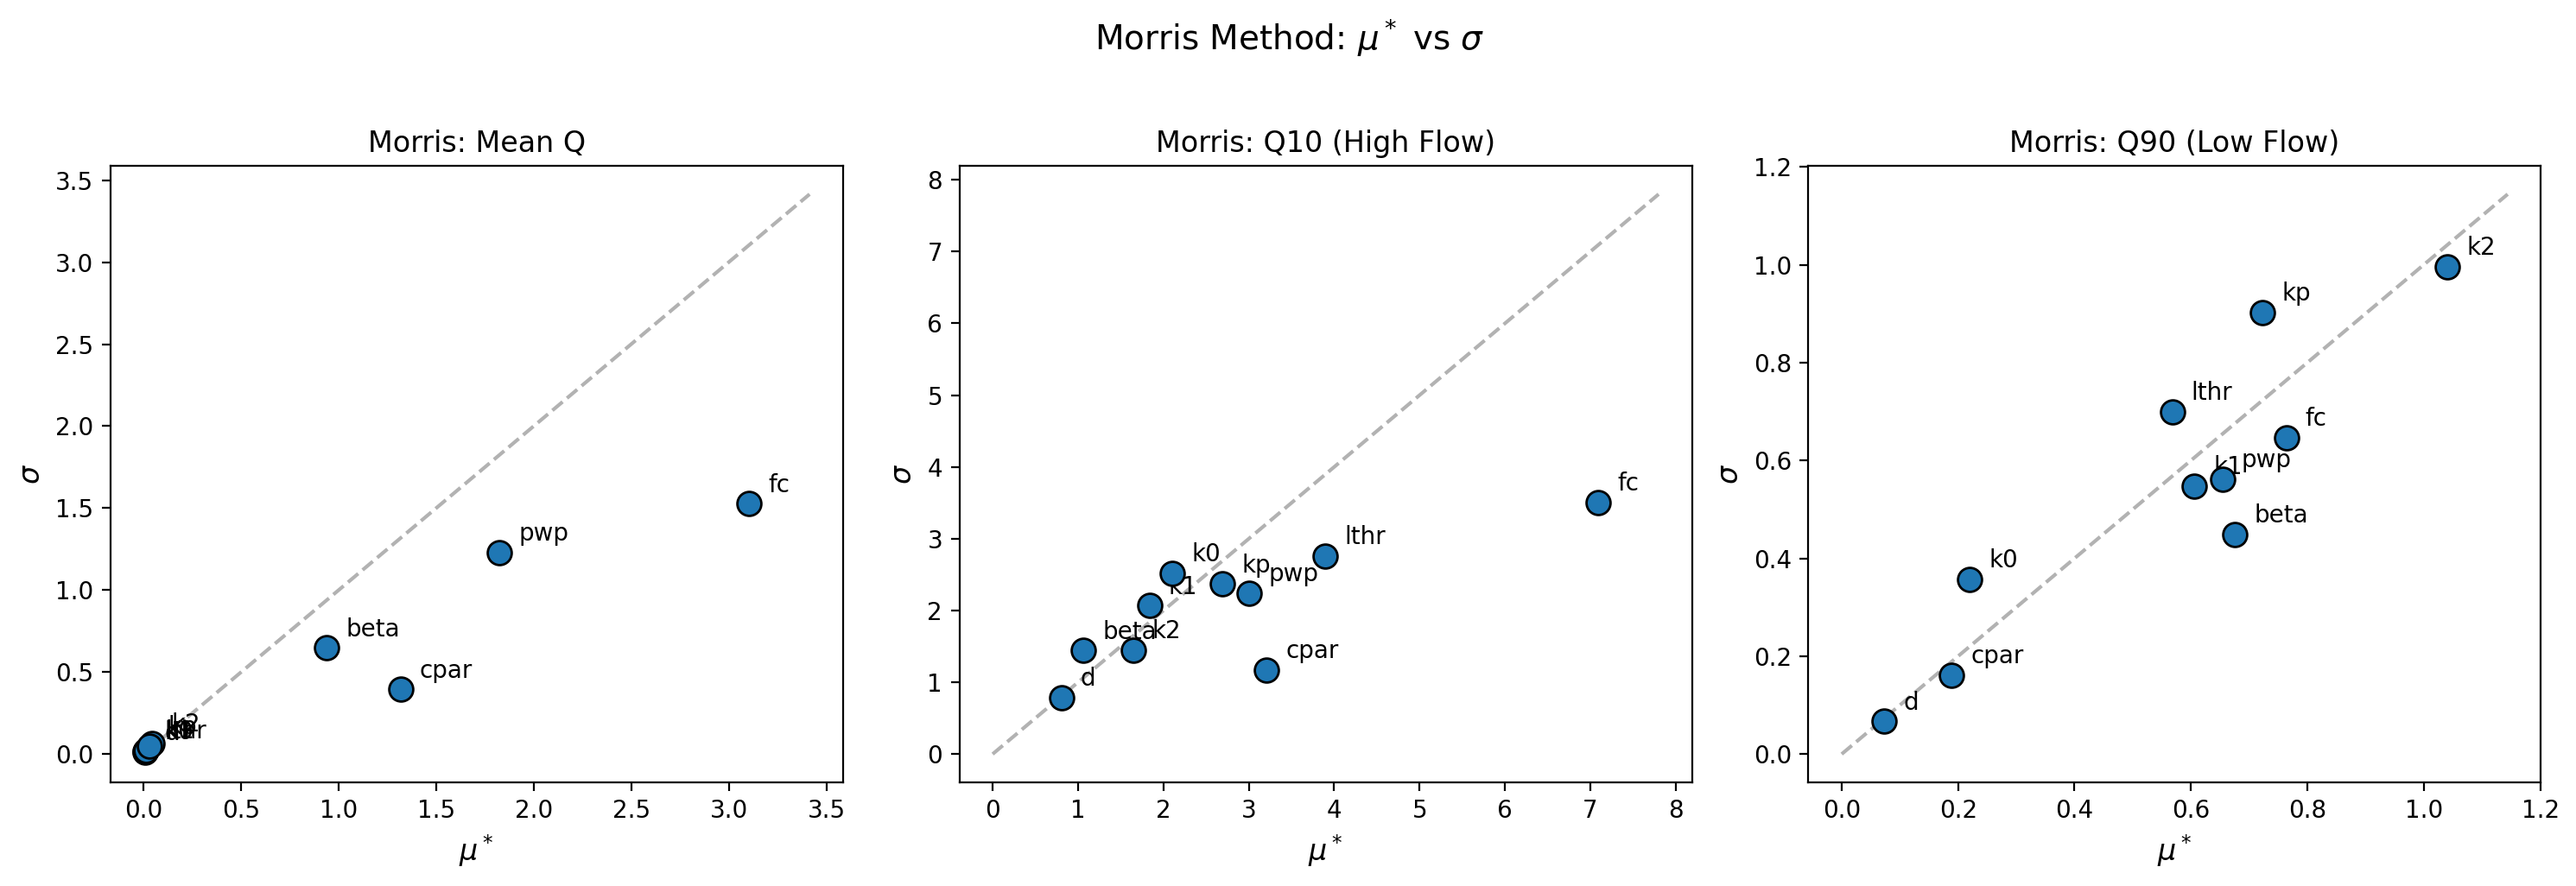

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, m in zip(axes, metrics_list):
    si = Si_morris[m]
    ax.scatter(si['mu_star'], si['sigma'], s=100, c='C0', edgecolors='k', zorder=5)
    for j in range(n_params):
        ax.annotate(param_names[j],
                    (si['mu_star'][j], si['sigma'][j]),
                    textcoords='offset points', xytext=(8, 5), fontsize=10)
    max_val = max(max(si['mu_star']), max(si['sigma'])) * 1.1
    ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.3)
    ax.set_xlabel(r'$\mu^*$', fontsize=12)
    ax.set_ylabel(r'$\sigma$', fontsize=12)
    ax.set_title(f'Morris: {metric_labels[m]}')

plt.suptitle(r'Morris Method: $\mu^*$ vs $\sigma$', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 4. Variance-based Sensitivity Analysis (Sobol Method)

Sobol analysis decomposes the output variance into contributions from each parameter:
- **First-order index ($S_1$)**: Direct (additive) contribution of each parameter alone
- **Second-order index ($S_{ij}$)**: Pairwise interaction between parameters $i$ and $j$
- **Total-order index ($S_T$)**: Includes all interactions (pairwise, three-way, etc.)

The difference $S_T - S_1$ indicates how much a parameter participates in interactions.
If $S_T \approx S_1$ for all parameters, the model is approximately additive.

We use the Saltelli sampling scheme (SALib) with `calc_second_order=True`, which requires
$N \times (2d + 2)$ model evaluations. With $N=256$ and $d=10$: $256 \times 22 = 5{,}632$ runs.

In [8]:
from SALib.sample import saltelli
from SALib.analyze import sobol

# Generate Saltelli samples with second-order enabled
X_sobol = saltelli.sample(problem, N=256, calc_second_order=True)
print(f"Sobol samples: {X_sobol.shape[0]} model evaluations")

# Run model once, compute all three metrics per evaluation
Y_sobol = {m: np.zeros(X_sobol.shape[0]) for m in metrics_list}

for i in range(X_sobol.shape[0]):
    Q = hbv_run_ts(X_sobol[i])
    Q_post = Q[WARMUP:]
    Y_sobol["mean_Q"][i] = np.mean(Q_post)
    Y_sobol["Q10"][i] = np.percentile(Q_post, 90)   # exceeded 10% of time
    Y_sobol["Q90"][i] = np.percentile(Q_post, 10)   # exceeded 90% of time
    if (i + 1) % 1000 == 0:
        print(f"  Completed {i+1}/{X_sobol.shape[0]}")

# Analyze for each metric
Si_sobol = {}
for m in metrics_list:
    Si_sobol[m] = sobol.analyze(problem, Y_sobol[m], calc_second_order=True)

for m in metrics_list:
    print(f"\n{metric_labels[m]}:")
    for j in range(n_params):
        print(f"  {param_names[j]:<8} S1={Si_sobol[m]['S1'][j]:>8.4f}  ST={Si_sobol[m]['ST'][j]:>8.4f}")

Sobol samples: 5632 model evaluations
  Completed 1000/5632
  Completed 2000/5632
  Completed 3000/5632
  Completed 4000/5632
  Completed 5000/5632

Mean Q:
  d        S1=  0.0000  ST=  0.0000
  fc       S1=  0.5160  ST=  0.6147
  beta     S1=  0.0661  ST=  0.0705
  cpar     S1=  0.1730  ST=  0.1732
  k0       S1=  0.0001  ST=  0.0000
  lthr     S1=  0.0001  ST=  0.0000
  k1       S1=  0.0001  ST=  0.0000
  k2       S1=  0.0004  ST=  0.0000
  kp       S1=  0.0004  ST=  0.0000
  pwp      S1=  0.1564  ST=  0.2280

Q10 (High Flow):
  d        S1=  0.0082  ST=  0.0080
  fc       S1=  0.4103  ST=  0.4892
  beta     S1=  0.0022  ST=  0.0181
  cpar     S1=  0.1478  ST=  0.1537
  k0       S1= -0.0262  ST=  0.0382
  lthr     S1=  0.1823  ST=  0.2207
  k1       S1=  0.0442  ST=  0.0461
  k2       S1=  0.0140  ST=  0.0322
  kp       S1=  0.0731  ST=  0.0781
  pwp      S1=  0.0656  ST=  0.1035

Q90 (Low Flow):
  d        S1= -0.0002  ST=  0.0024
  fc       S1=  0.1443  ST=  0.2142
  beta     S1=  

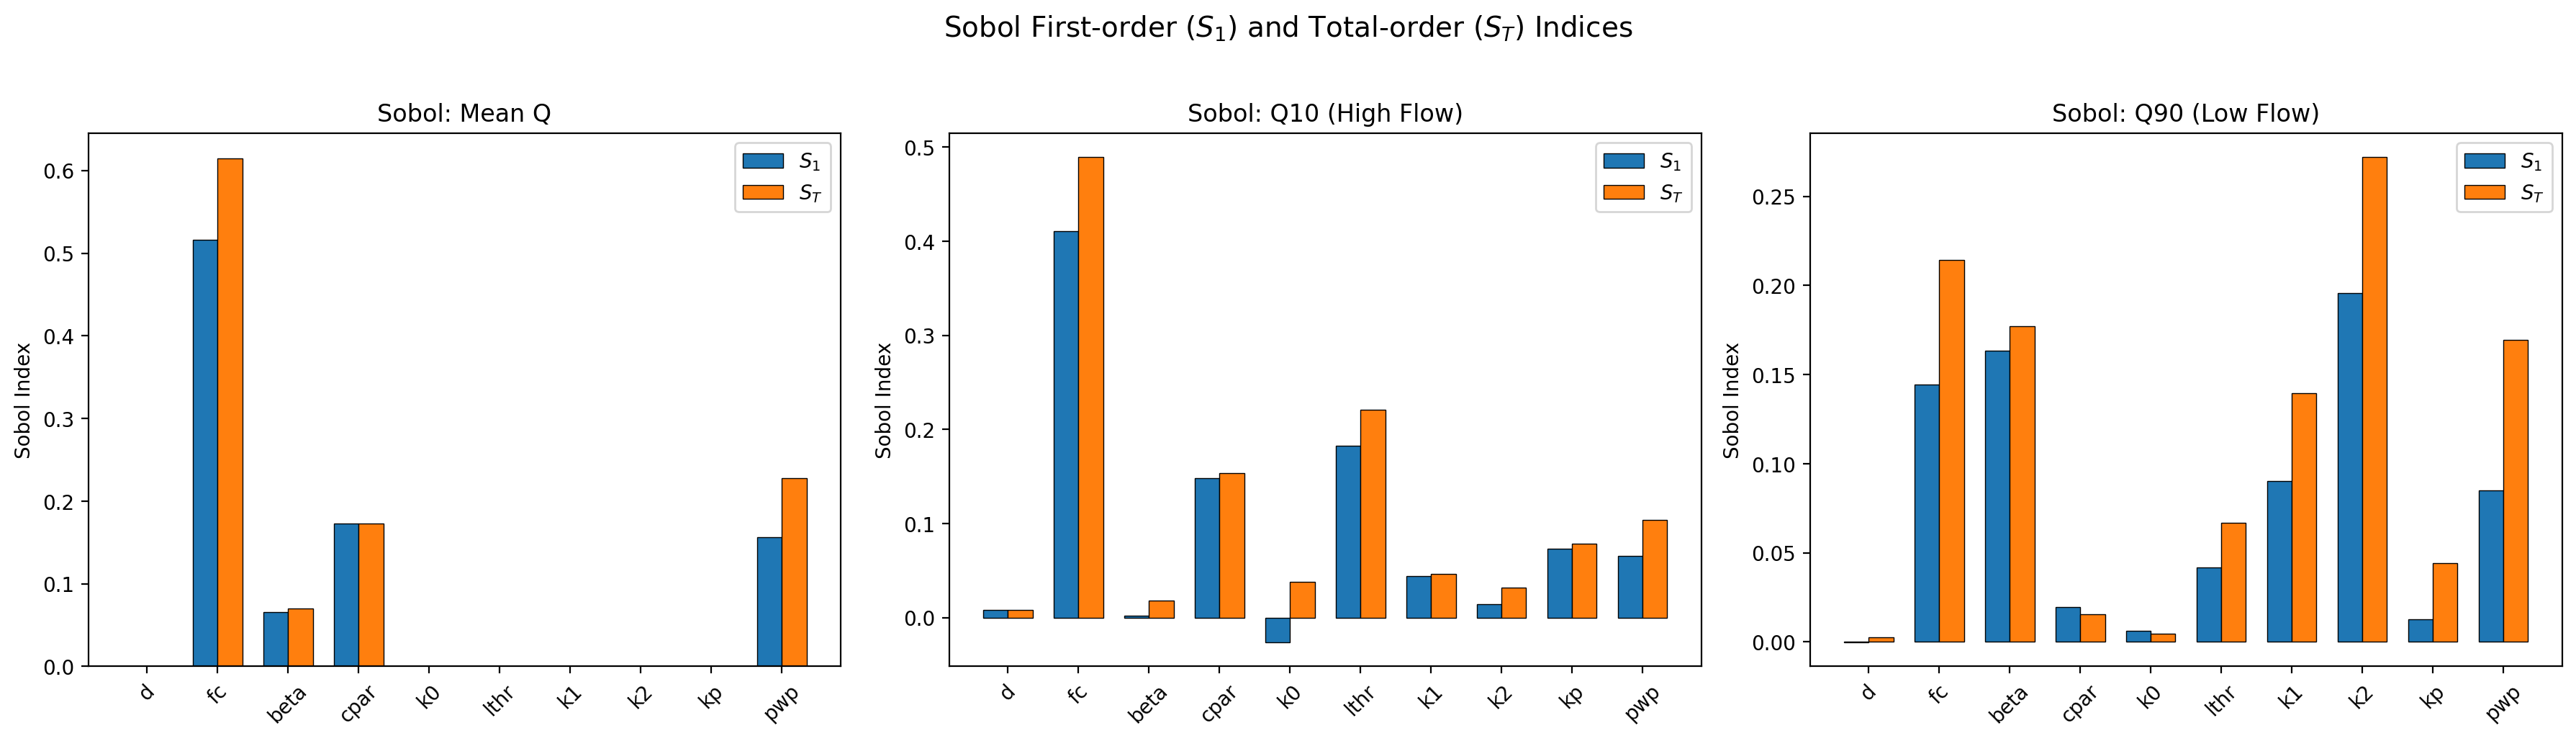

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
x = np.arange(n_params)
X_sobol = pd.DataFrame(X_sobol, columns=param_names)
width = 0.35

for ax, m in zip(axes, metrics_list):
    ax.bar(x - width/2, Si_sobol[m]['S1'], width, label='$S_1$',
           color='C0', edgecolor='k', linewidth=0.5)
    ax.bar(x + width/2, Si_sobol[m]['ST'], width, label='$S_T$',
           color='C1', edgecolor='k', linewidth=0.5)
    ax.set_xticks(x)
    ax.set_xticklabels(param_names, rotation=45)
    ax.set_ylabel('Sobol Index')
    ax.set_title(f'Sobol: {metric_labels[m]}')
    ax.legend()

plt.suptitle('Sobol First-order ($S_1$) and Total-order ($S_T$) Indices', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

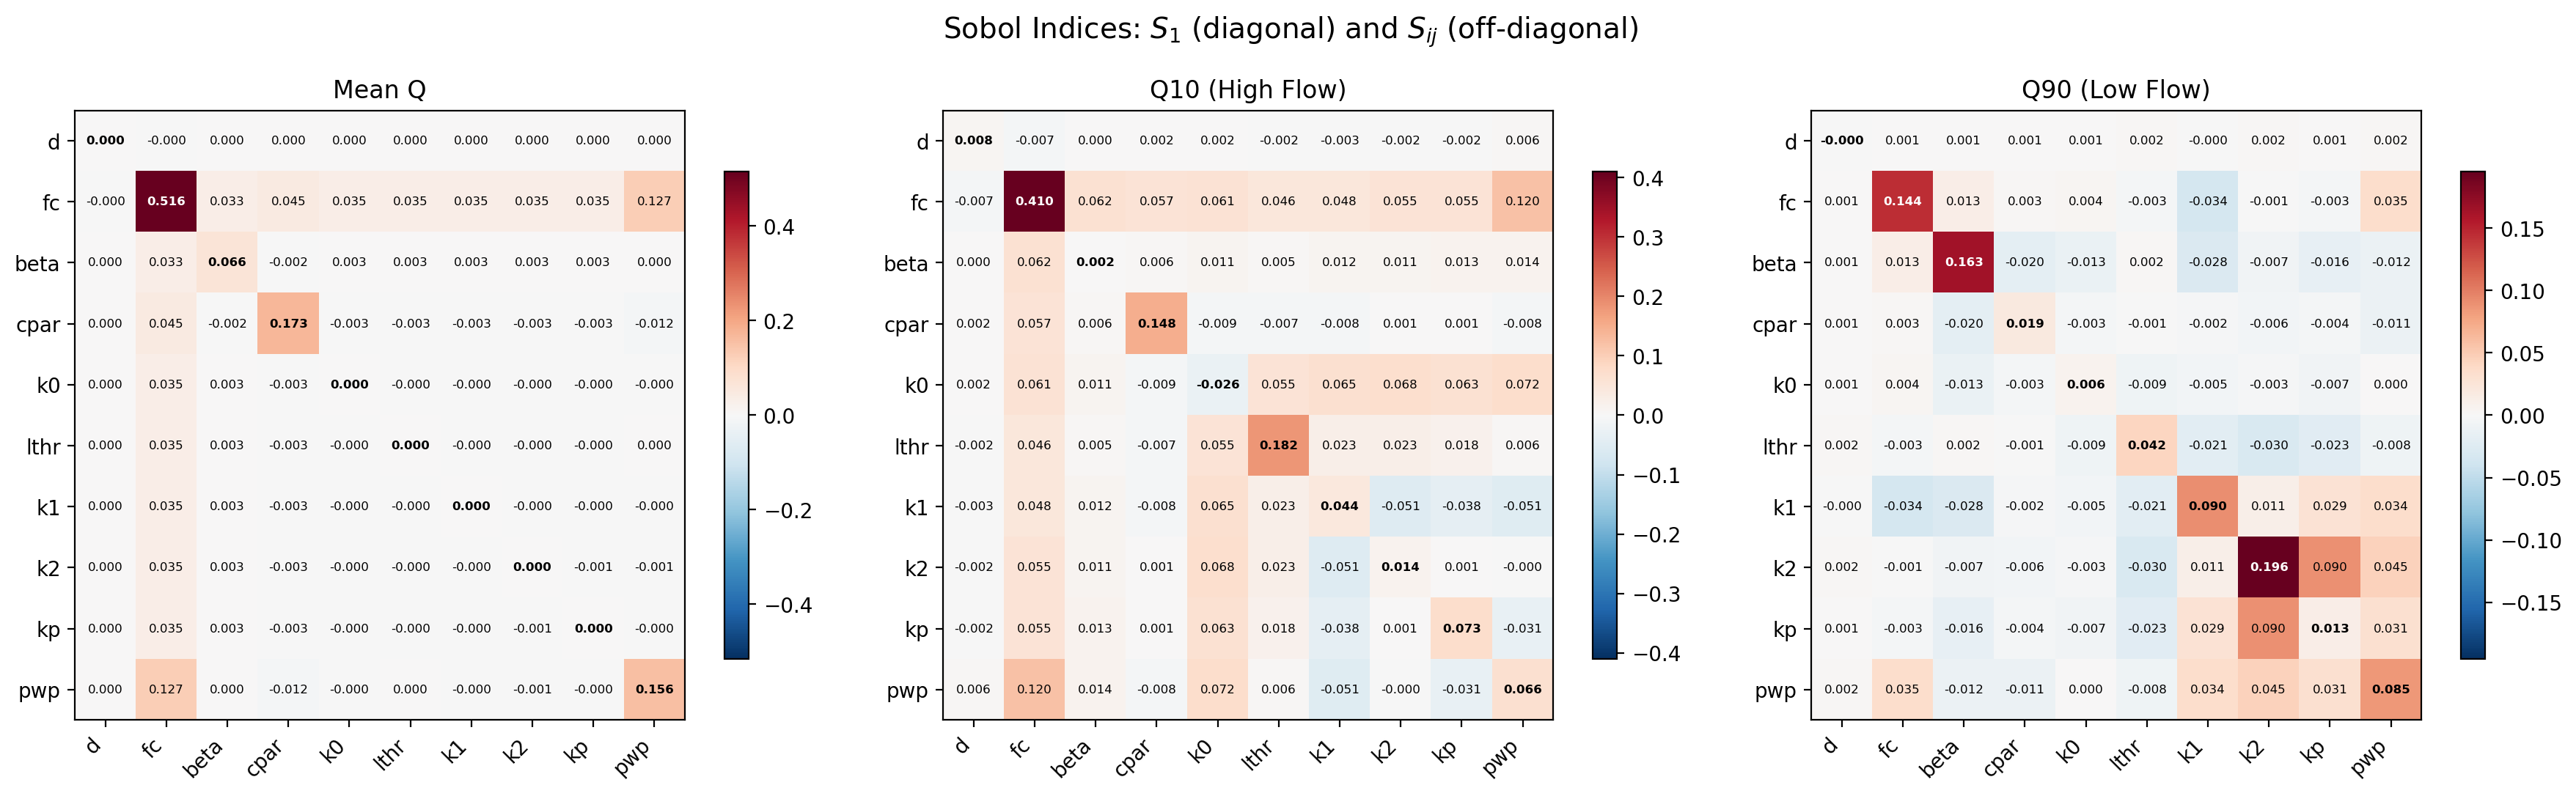

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, m in zip(axes, metrics_list):
    S2_raw = Si_sobol[m]['S2'].copy()
    S1 = Si_sobol[m]['S1']

    # SALib S2 is upper-triangular with NaN elsewhere — zero out NaN before mirroring
    S2_clean = np.where(np.isnan(S2_raw), 0.0, S2_raw)
    S2_full = S2_clean + S2_clean.T  # symmetric off-diagonal

    # Place S1 on the diagonal
    np.fill_diagonal(S2_full, S1)

    # Diverging colormap centered at 0
    vmax = np.nanmax(np.abs(S2_full))
    im = ax.imshow(S2_full, cmap='RdBu_r', aspect='equal',
                   vmin=-vmax, vmax=vmax)

    # Annotate cells with values
    for i in range(n_params):
        for j in range(n_params):
            val = S2_full[i, j]
            color = 'white' if abs(val) > 0.6 * vmax else 'black'
            fontweight = 'bold' if i == j else 'normal'
            ax.text(j, i, f'{val:.3f}', ha='center', va='center',
                    fontsize=6, color=color, fontweight=fontweight)

    ax.set_xticks(range(n_params))
    ax.set_xticklabels(param_names, rotation=45, ha='right')
    ax.set_yticks(range(n_params))
    ax.set_yticklabels(param_names)
    ax.set_title(f'{metric_labels[m]}')
    plt.colorbar(im, ax=ax, shrink=0.8)

plt.suptitle(r'Sobol Indices: $S_1$ (diagonal) and $S_{ij}$ (off-diagonal)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

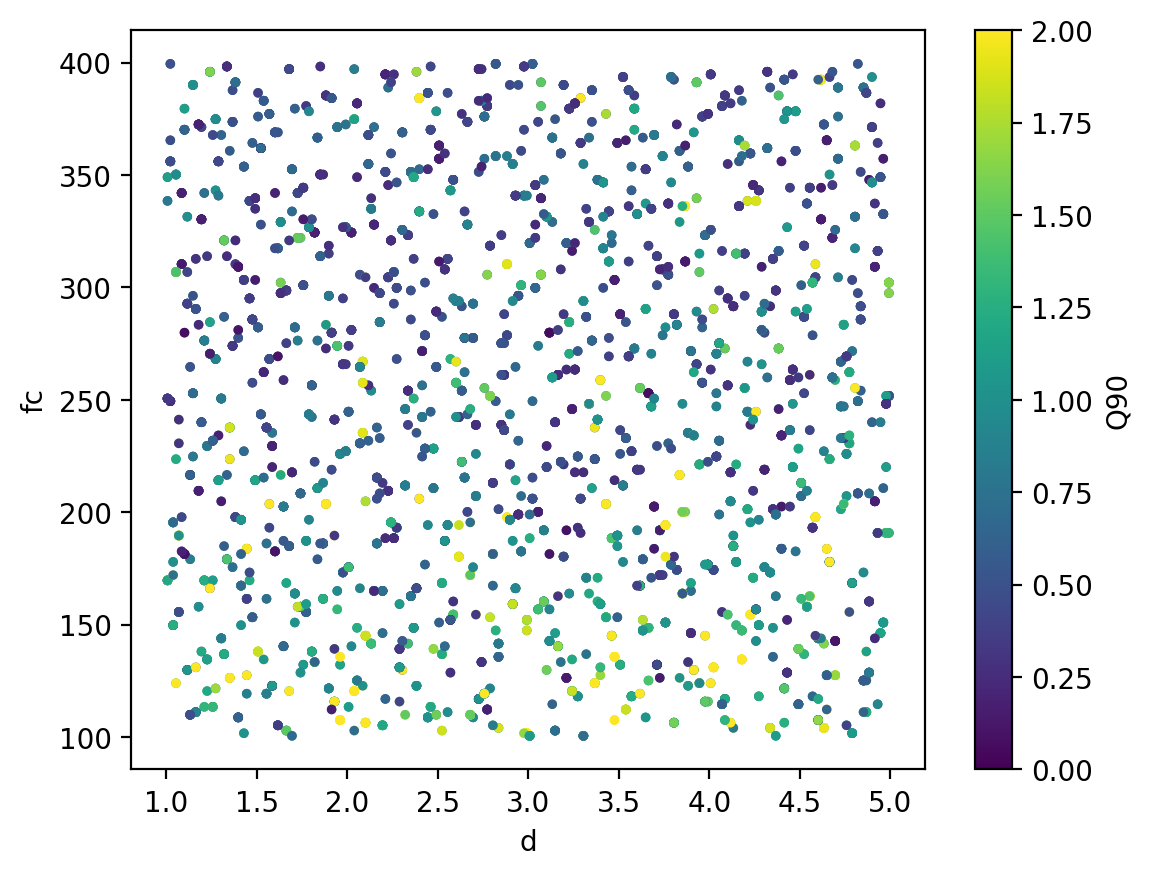

In [45]:
# Scatter plot colored by Q90 value
para_A = 'd' # change to the parameters of your interests
para_B = 'fc'
plt.scatter(X_sobol[para_A],X_sobol[para_B],c = Y_sobol['Q90'],vmin = 0, vmax = 2, s= 6)
plt.xlabel(para_A)
plt.ylabel(para_B)
plt.colorbar(label="Q90")

## 5. Distance-based Global Sensitivity Analysis (DGSA)

DGSA (Fenwick et al., 2014) is a non-parametric global sensitivity method that:
1. Clusters model responses using K-Medoids
2. Compares parameter distributions across clusters via L1-norm distance
3. Uses bootstrap significance testing (sensitivity > 1 = significant)

We use [pyDGSA](https://github.com/zperzan/pyDGSA) which also supports **interaction effects**.

### How DGSA Handles Multivariate Responses

The previous methods (OAT, Morris, Sobol) all require a **scalar output** — that is why
we ran each of them separately for Mean Q, Q10, and Q90. Each analysis captures sensitivity
to *one aspect* of the hydrograph at a time.

DGSA takes a fundamentally different approach. Instead of reducing the response to a scalar,
it works with the **full response vector** — in our case, the entire post-warmup discharge
time series (~3,300 daily values per simulation). The workflow is:

1. **Compute pairwise distances** between all response vectors (Euclidean distance between
   two time series of length $T$ gives a single number summarizing how different they are)
2. **Cluster** the responses (via K-Medoids on the distance matrix) into groups with
   similar hydrograph behavior
3. **Compare parameter CDFs** across clusters — if a parameter's distribution shifts
   significantly between clusters, it is sensitive

This means DGSA captures sensitivity to the **overall hydrograph shape, timing, and magnitude
simultaneously**, rather than one summary statistic at a time. 

In [11]:
# Generate LHS ensemble
N_SAMPLES = 1000
sampler = qmc.LatinHypercube(d=n_params, seed=42)
lhs_unit = sampler.random(n=N_SAMPLES)
lhs_samples = qmc.scale(lhs_unit, lower_bounds, upper_bounds)

# Run ensemble
print(f"Running {N_SAMPLES} LHS simulations...")
Q_ensemble = np.zeros((N_SAMPLES, len(forcing)))
for i in range(N_SAMPLES):
    Q_ensemble[i] = hbv_run_ts(lhs_samples[i])
    if (i + 1) % 200 == 0:
        print(f"  Completed {i+1}/{N_SAMPLES}")

print(f"Ensemble shape: {Q_ensemble.shape}")

Running 1000 LHS simulations...
  Completed 200/1000
  Completed 400/1000
  Completed 600/1000
  Completed 800/1000
  Completed 1000/1000
Ensemble shape: (1000, 3652)


In [12]:
from scipy.spatial.distance import pdist, squareform
from pyDGSA.cluster import KMedoids
from pyDGSA.dgsa import dgsa, dgsa_interactions
from pyDGSA.plot import vert_pareto_plot, plot_cdf

# Use the post-warmup time series as multivariate response
Q_post = Q_ensemble[:, WARMUP:]
time_post = forcing["Time"].values[WARMUP:]

# Compute pairwise distances between response time series
distances = squareform(pdist(Q_post, metric="euclidean"))

# Cluster responses
n_clusters = 3
clusterer = KMedoids(n_clusters=n_clusters, max_iter=3000, tol=1e-4)
labels, medoids = clusterer.fit_predict(distances)

cluster_names = ["Cluster A", "Cluster B", "Cluster C"]

# Sort cluster names by mean discharge of each cluster
cluster_means = [np.mean(Q_post[labels == k]) for k in range(n_clusters)]
order = np.argsort(cluster_means)
label_map = {old: new for new, old in enumerate(order)}
labels_sorted = np.array([label_map[l] for l in labels])
medoids_sorted = [medoids[order[k]] for k in range(n_clusters)]

print(f"Cluster sizes: {[np.sum(labels_sorted == k) for k in range(n_clusters)]}")
for k in range(n_clusters):
    print(f"  {cluster_names[k]}: mean Q = {np.mean(Q_post[labels_sorted == k]):.2f} m3/s")

Cluster sizes: [np.int64(421), np.int64(362), np.int64(217)]
  Cluster A: mean Q = 6.19 m3/s
  Cluster B: mean Q = 6.19 m3/s
  Cluster C: mean Q = 7.88 m3/s


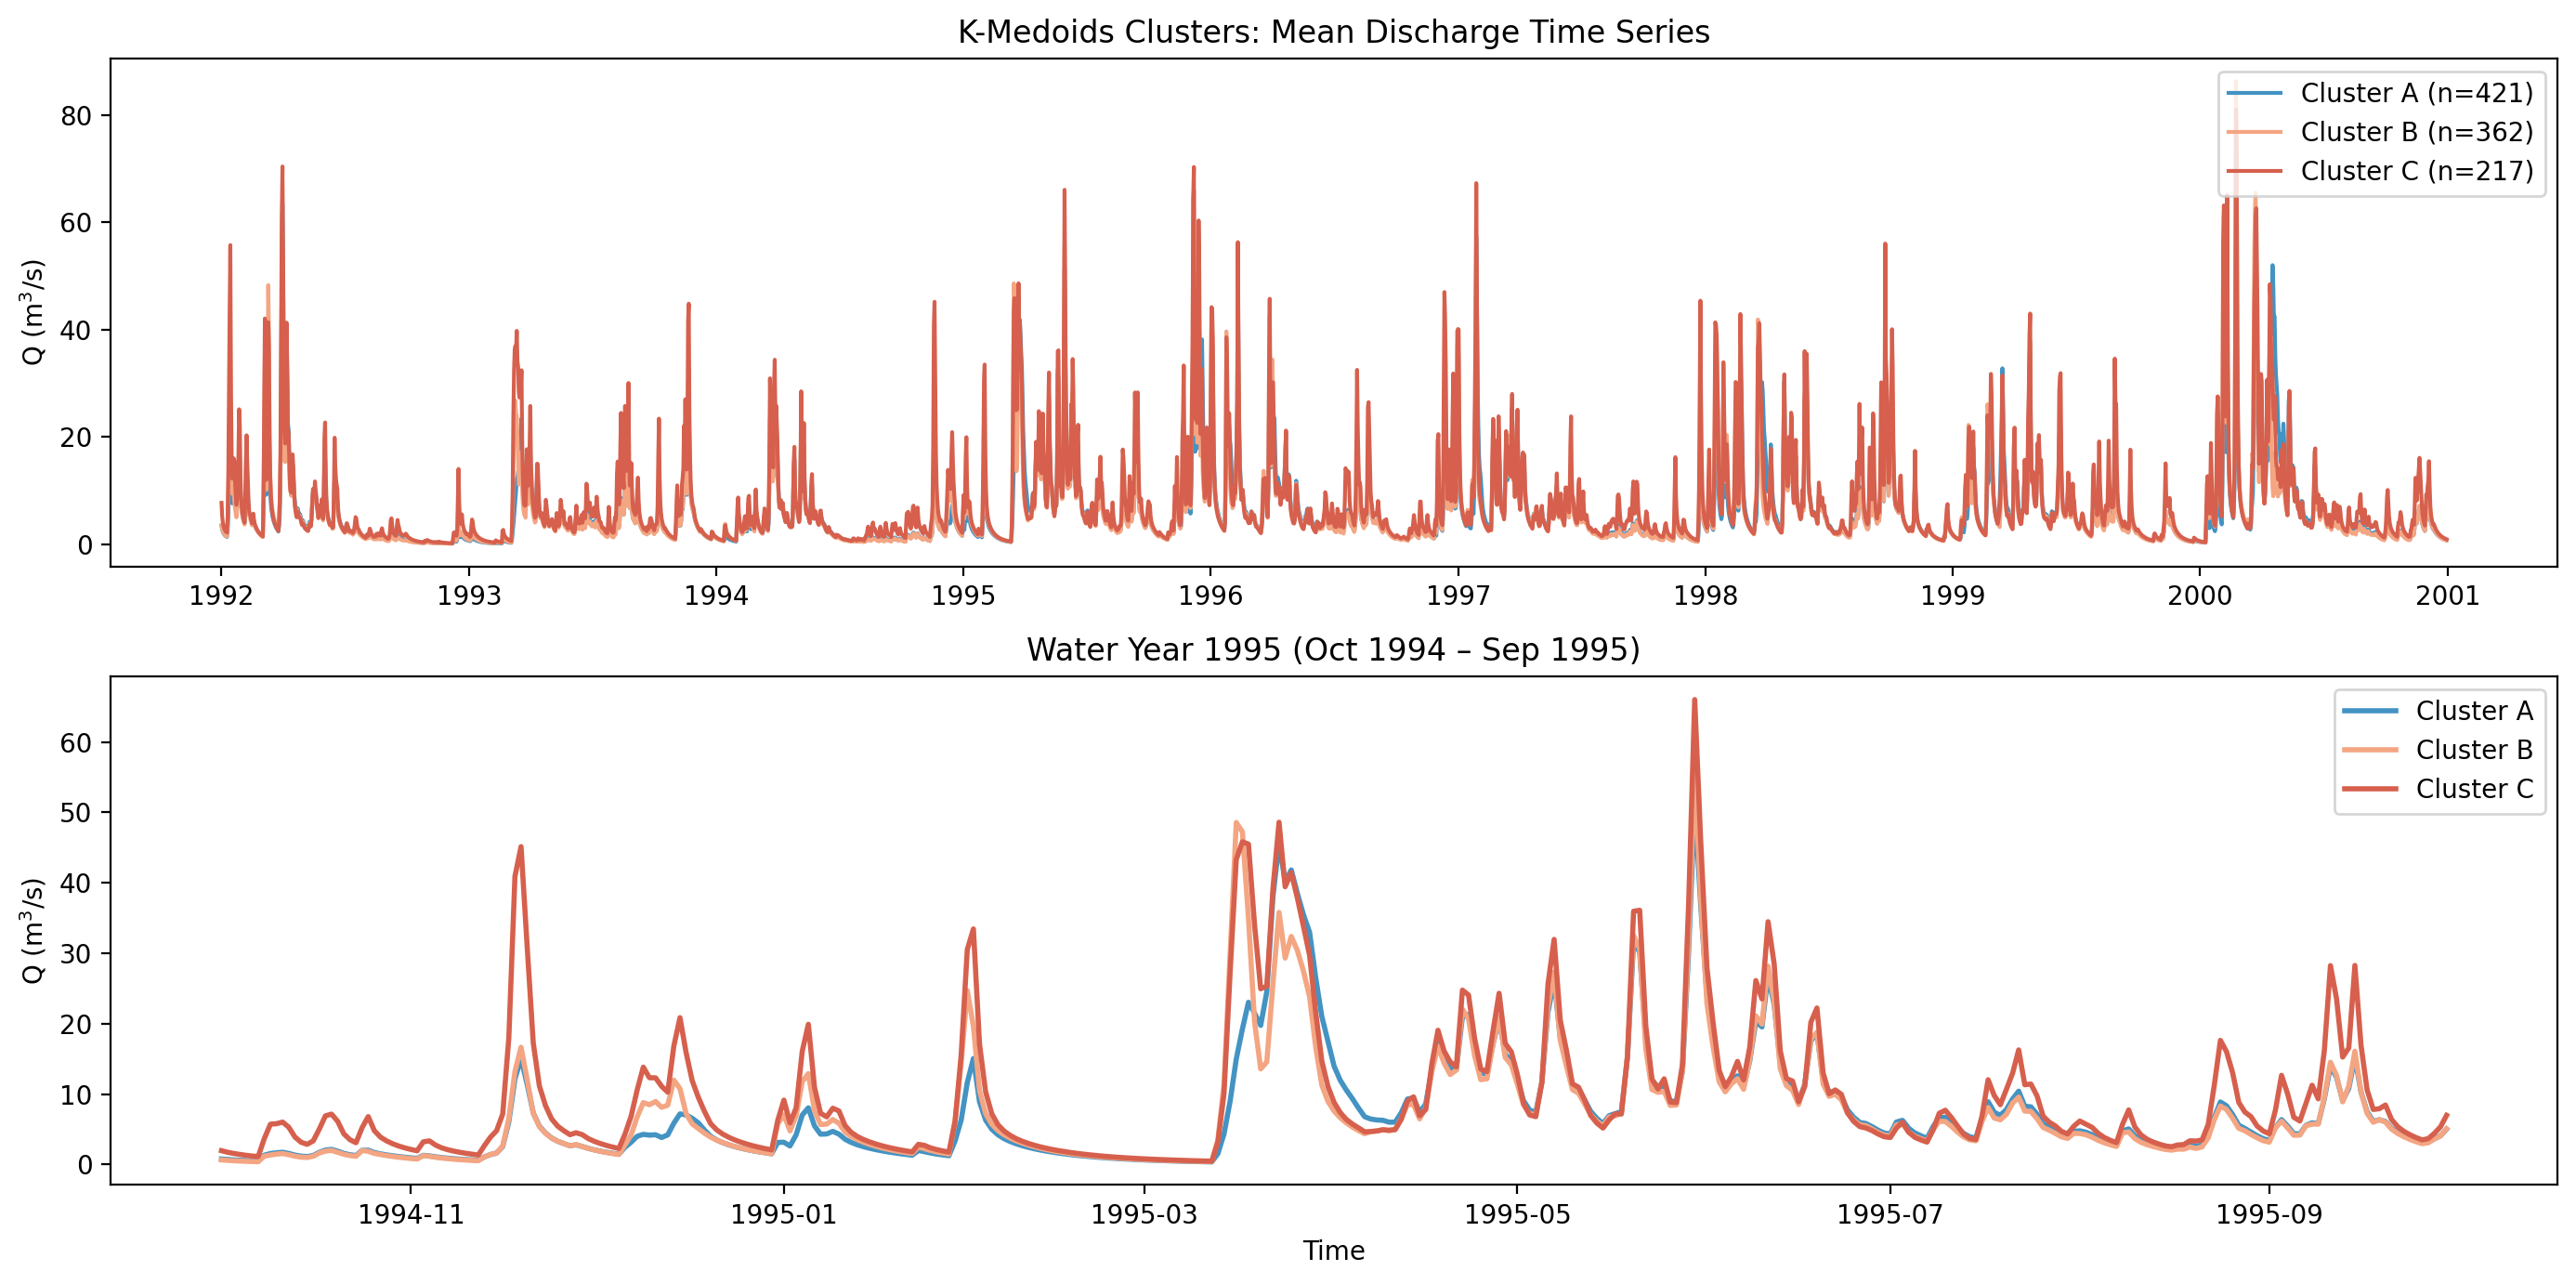

In [13]:
cluster_colors = ["#4393c3", "#f4a582", "#d6604d"]

fig, axes = plt.subplots(2, 1, figsize=(14, 7))

# Full time series
ax = axes[0]
for k in range(n_clusters):
    mask = labels_sorted == k
    mu = Q_post[mask].mean(axis=0)
    ax.plot(time_post, mu, color=cluster_colors[k], lw=1.5,
            label=f'{cluster_names[k]} (n={mask.sum()})')
ax.set_ylabel('Q (m$^3$/s)')
ax.set_title('K-Medoids Clusters: Mean Discharge Time Series')
ax.legend(loc='upper right')

# Zoom into water year 1995 (Oct 1994 – Sep 1995)
ax = axes[1]
wy_mask = (time_post >= np.datetime64('1994-10-01')) & (time_post < np.datetime64('1995-10-01'))
for k in range(n_clusters):
    mask = labels_sorted == k
    mu = Q_post[mask].mean(axis=0)
    ax.plot(time_post[wy_mask], mu[wy_mask], color=cluster_colors[k], lw=2,
            label=f'{cluster_names[k]}')
ax.set_xlabel('Time')
ax.set_ylabel('Q (m$^3$/s)')
ax.set_title('Water Year 1995 (Oct 1994 – Sep 1995)')
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

Computing DGSA main effects...


  0%|          | 0/3000 [00:00<?, ?it/s]


DGSA Main Effect Sensitivities:
      sensitivity  confidence
d        8.026598    5.093169
fc       5.100280    3.130098
beta     1.562133    0.962221
cpar     1.793291    1.119782
k0       2.170406    1.403256
lthr     1.265980    0.806254
k1       1.177300    0.736736
k2       0.370999    0.226427
kp       1.236379    0.784382
pwp      2.132812    1.327045


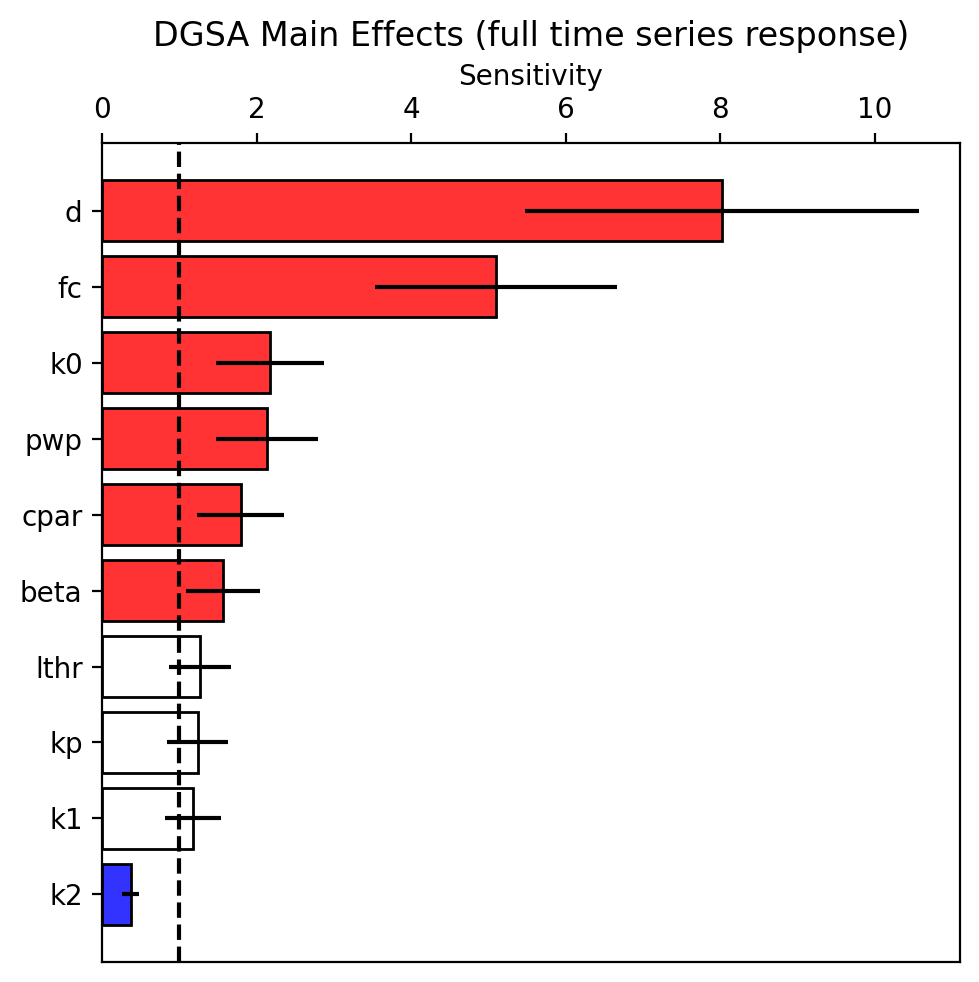

In [14]:
# Main effects
print("Computing DGSA main effects...")
dgsa_main = dgsa(
    lhs_samples, labels_sorted,
    parameter_names=param_names, n_boots=3000, confidence=True
)
print("\nDGSA Main Effect Sensitivities:")
print(dgsa_main)

fig, ax = vert_pareto_plot(dgsa_main, confidence=True)
ax.set_title('DGSA Main Effects (full time series response)')
plt.tight_layout()
plt.show()

  0%|          | 0/3000 [00:00<?, ?it/s]

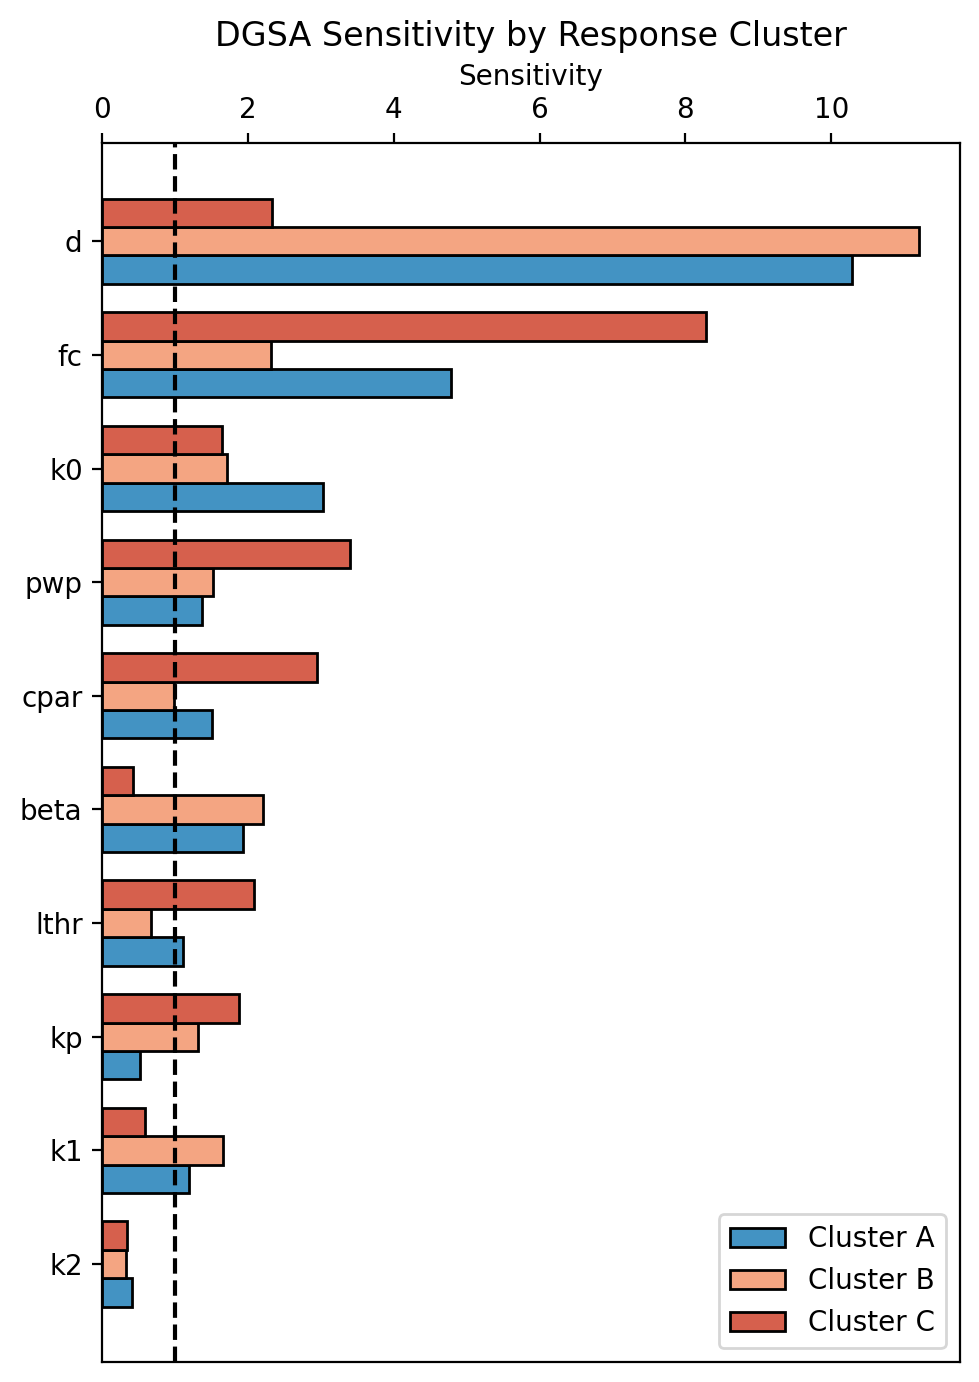

In [15]:
# Per-cluster sensitivity
dgsa_cluster = dgsa(
    lhs_samples, labels_sorted,
    parameter_names=param_names, n_boots=3000,
    output="cluster_avg", cluster_names=cluster_names
)

fig, ax = vert_pareto_plot(dgsa_cluster, fmt="cluster_avg", colors=cluster_colors)
ax.set_title('DGSA Sensitivity by Response Cluster')
plt.tight_layout()
plt.show()

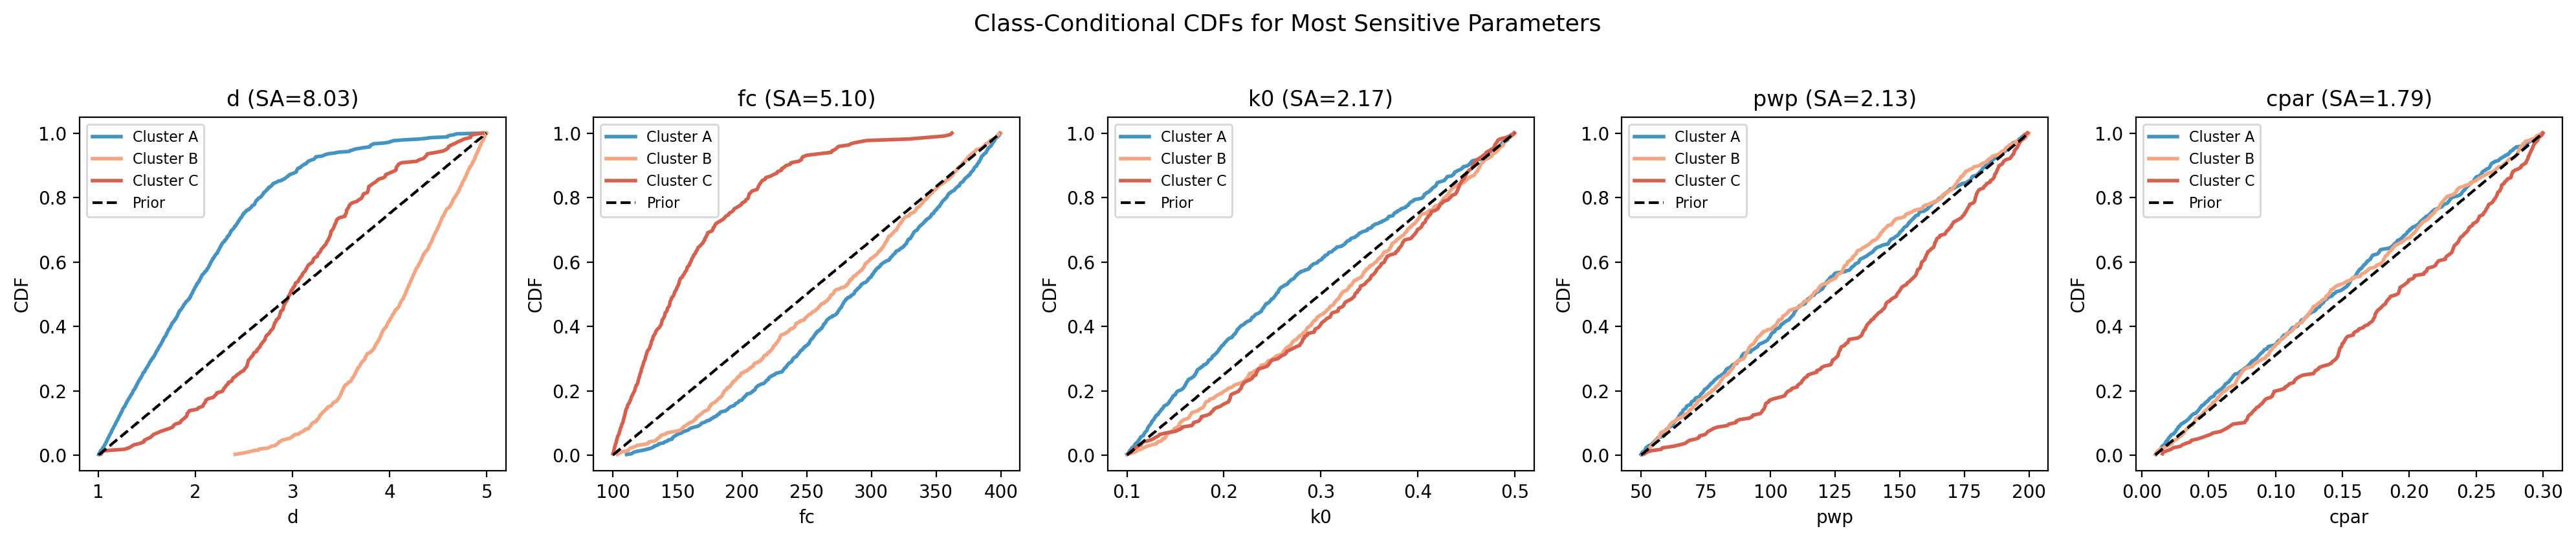

In [16]:
# CDF plots for the most sensitive parameters
top_params = dgsa_main.sort_values('sensitivity', ascending=False).index[:5].tolist()

fig, axes = plt.subplots(1, len(top_params), figsize=(4*len(top_params), 4))
for ax, p in zip(axes, top_params):
    p_idx = param_names.index(p)
    for k in range(n_clusters):
        vals = np.sort(lhs_samples[labels_sorted == k, p_idx])
        cdf = np.arange(1, len(vals)+1) / len(vals)
        ax.plot(vals, cdf, color=cluster_colors[k], lw=2, label=cluster_names[k])
    # Prior
    vals_all = np.sort(lhs_samples[:, p_idx])
    cdf_all = np.arange(1, len(vals_all)+1) / len(vals_all)
    ax.plot(vals_all, cdf_all, 'k--', lw=1.5, label='Prior')
    ax.set_xlabel(p)
    ax.set_ylabel('CDF')
    ax.set_title(f'{p} (SA={dgsa_main.loc[p, "sensitivity"]:.2f})')
    ax.legend(fontsize=8)

plt.suptitle('Class-Conditional CDFs for Most Sensitive Parameters', fontsize=13, y=1.03)
plt.tight_layout()
plt.show()

### 5.1 DGSA Interaction Effects

DGSA can also quantify **parameter interactions**: the sensitivity of parameter A
conditioned on parameter B. If `A | B` has high sensitivity, it means A's influence
depends on the value of B.

Computing DGSA interaction effects (this may take a few minutes)...


Performing DGSA:   0%|          | 0/10 [00:00<?, ?it/s]

Resampling parameter 0:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 1:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 2:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 3:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 4:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 5:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 6:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 7:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 8:   0%|          | 0/3 [00:00<?, ?it/s]

Resampling parameter 9:   0%|          | 0/3 [00:00<?, ?it/s]


Top 15 Interaction Sensitivities:
          sensitivity
k1 | d       1.299616
k0 | d       1.244524
fc | d       1.199865
d | k0       1.129675
d | fc       1.095182
d | k1       1.030902
fc | k0      0.989665
beta | d     0.974656
fc | cpar    0.960159
cpar | fc    0.940408
pwp | d      0.922782
pwp | fc     0.911312
lthr | fc    0.830333
cpar | d     0.827627
k0 | fc      0.826914


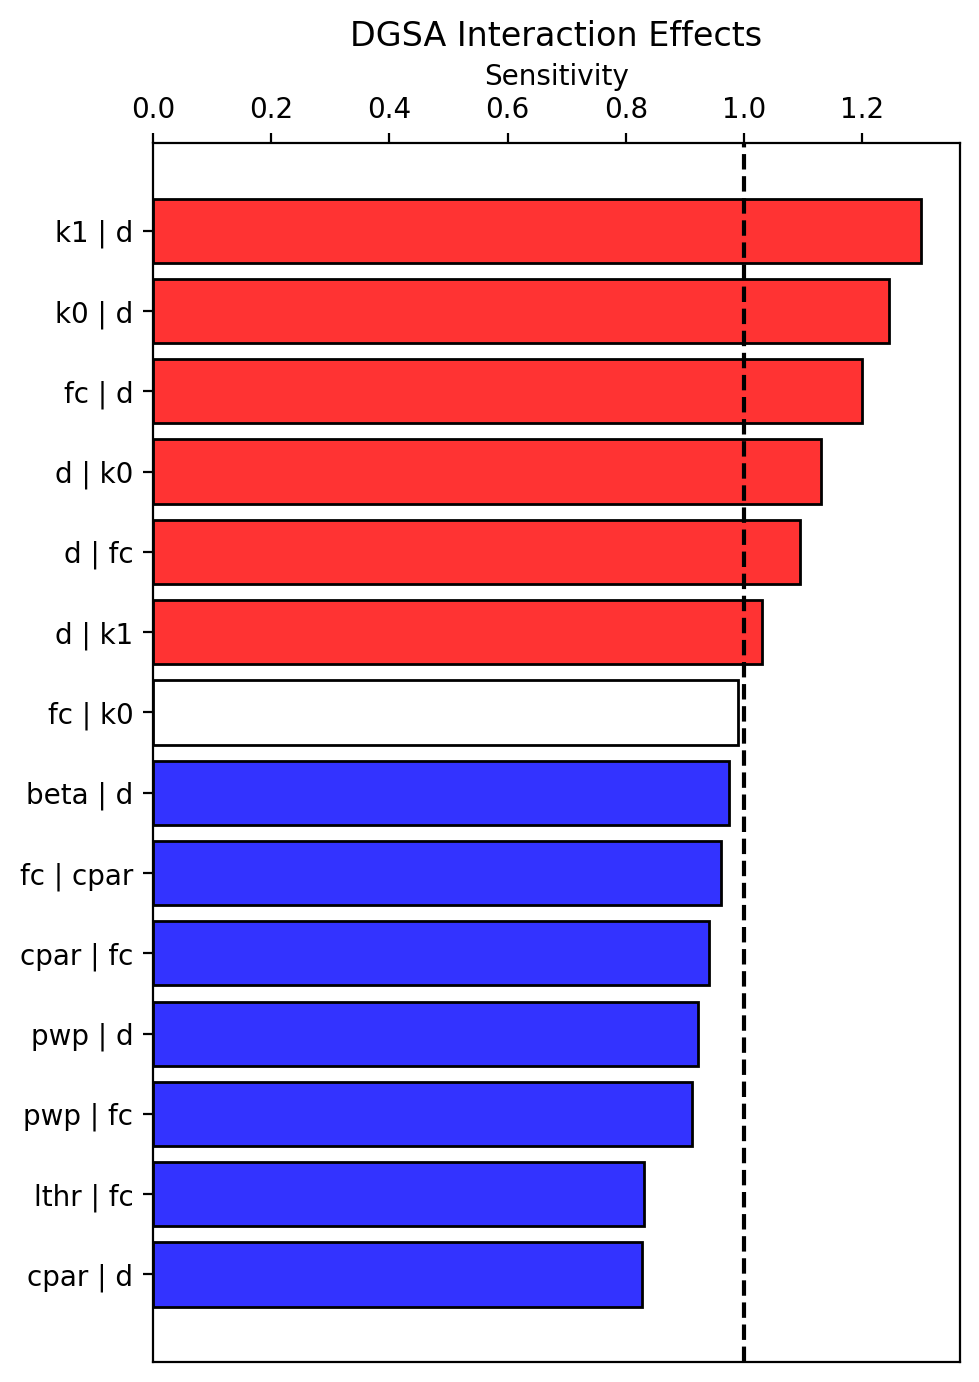

In [17]:
print("Computing DGSA interaction effects (this may take a few minutes)...")
dgsa_interact = dgsa_interactions(
    lhs_samples, labels_sorted,
    parameter_names=param_names, n_bins=3, n_boots=1000
)

print("\nTop 15 Interaction Sensitivities:")
print(dgsa_interact.head(15))

fig, ax = vert_pareto_plot(dgsa_interact, np_plot="+8")
ax.set_title('DGSA Interaction Effects')
plt.tight_layout()
plt.show()

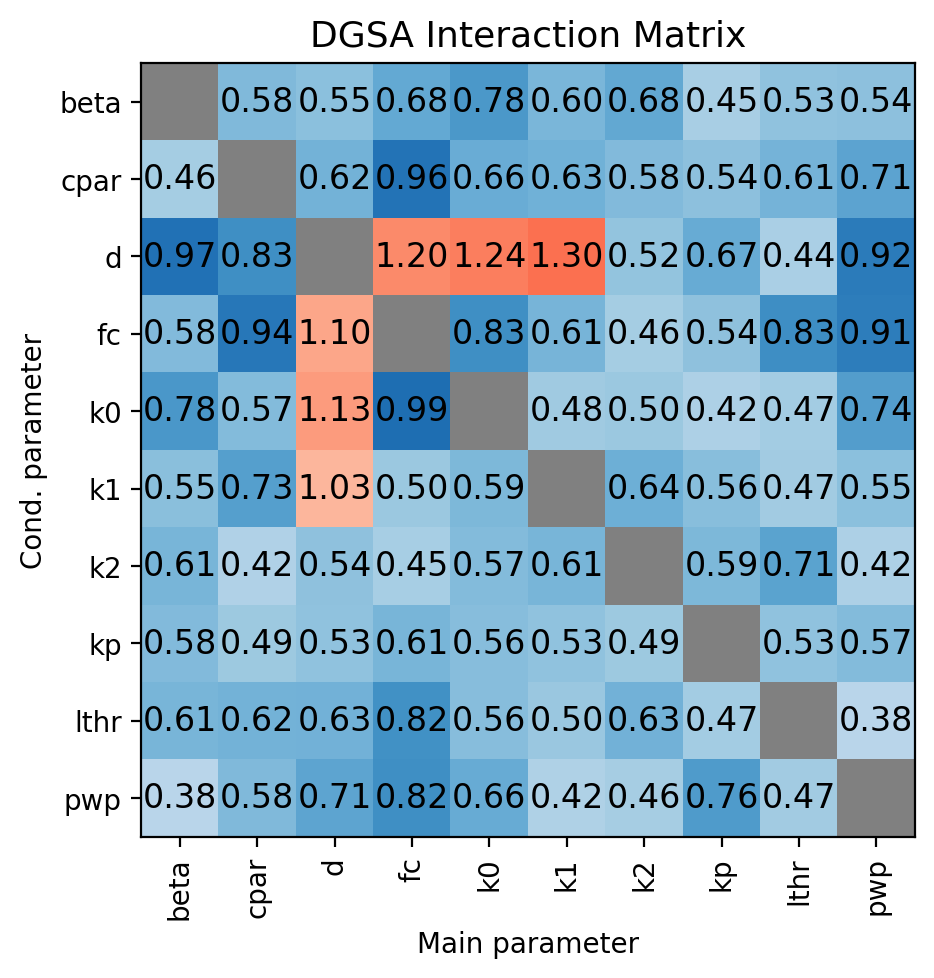

In [18]:
from pyDGSA.plot import interaction_matrix

fig, ax = interaction_matrix(dgsa_interact)
ax.set_title('DGSA Interaction Matrix', fontsize=13)
plt.tight_layout()
plt.show()

## 6. Comparison of Sensitivity Analysis Methods

We compare parameter rankings across all four methods and three metrics.

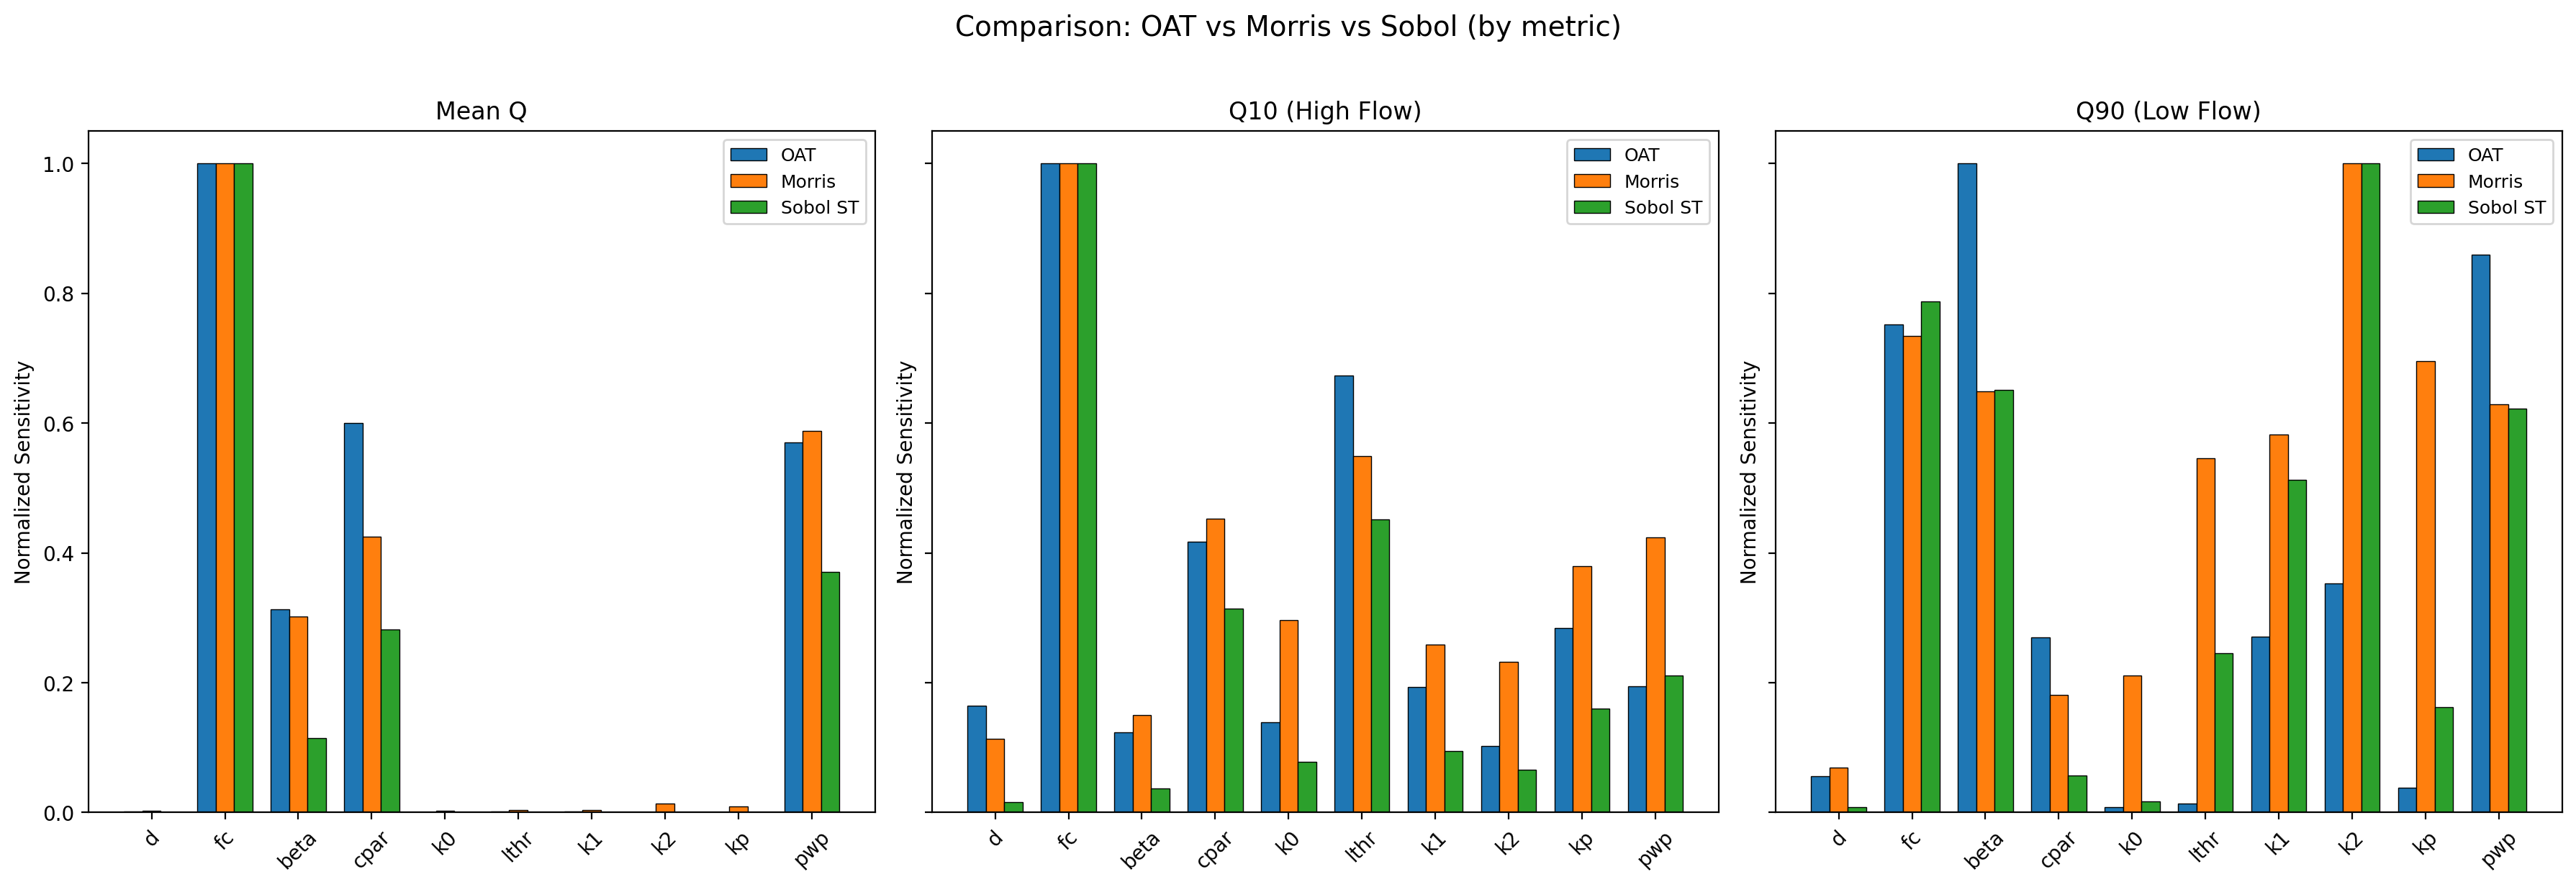

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for ax, m in zip(axes, metrics_list):
    comp = pd.DataFrame({
        'OAT': np.abs(oat_elasticities[m]),
        'Morris': Si_morris[m]['mu_star'],
        'Sobol ST': Si_sobol[m]['ST'],
    }, index=param_names)
    comp_norm = comp / comp.max()

    x = np.arange(n_params)
    width = 0.25
    for j, (method, color) in enumerate(zip(comp_norm.columns, ['C0', 'C1', 'C2'])):
        ax.bar(x + j*width - width, comp_norm[method], width,
               label=method, color=color, edgecolor='k', linewidth=0.5)
    ax.set_xticks(x)
    ax.set_xticklabels(param_names, rotation=45)
    ax.set_title(f'{metric_labels[m]}')
    ax.set_ylabel('Normalized Sensitivity')
    ax.legend(fontsize=9)

plt.suptitle('Comparison: OAT vs Morris vs Sobol (by metric)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

Parameter Rankings (1 = most sensitive):
      OAT  Morris  Sobol ST  DGSA
d       6      10         7     1
fc      1       1         1     2
beta    4       4         4     6
cpar    2       3         3     5
k0     10       9        10     3
lthr    7       8         9     7
k1      5       7         6     9
k2      8       5         5    10
kp      9       6         8     8
pwp     3       2         2     4


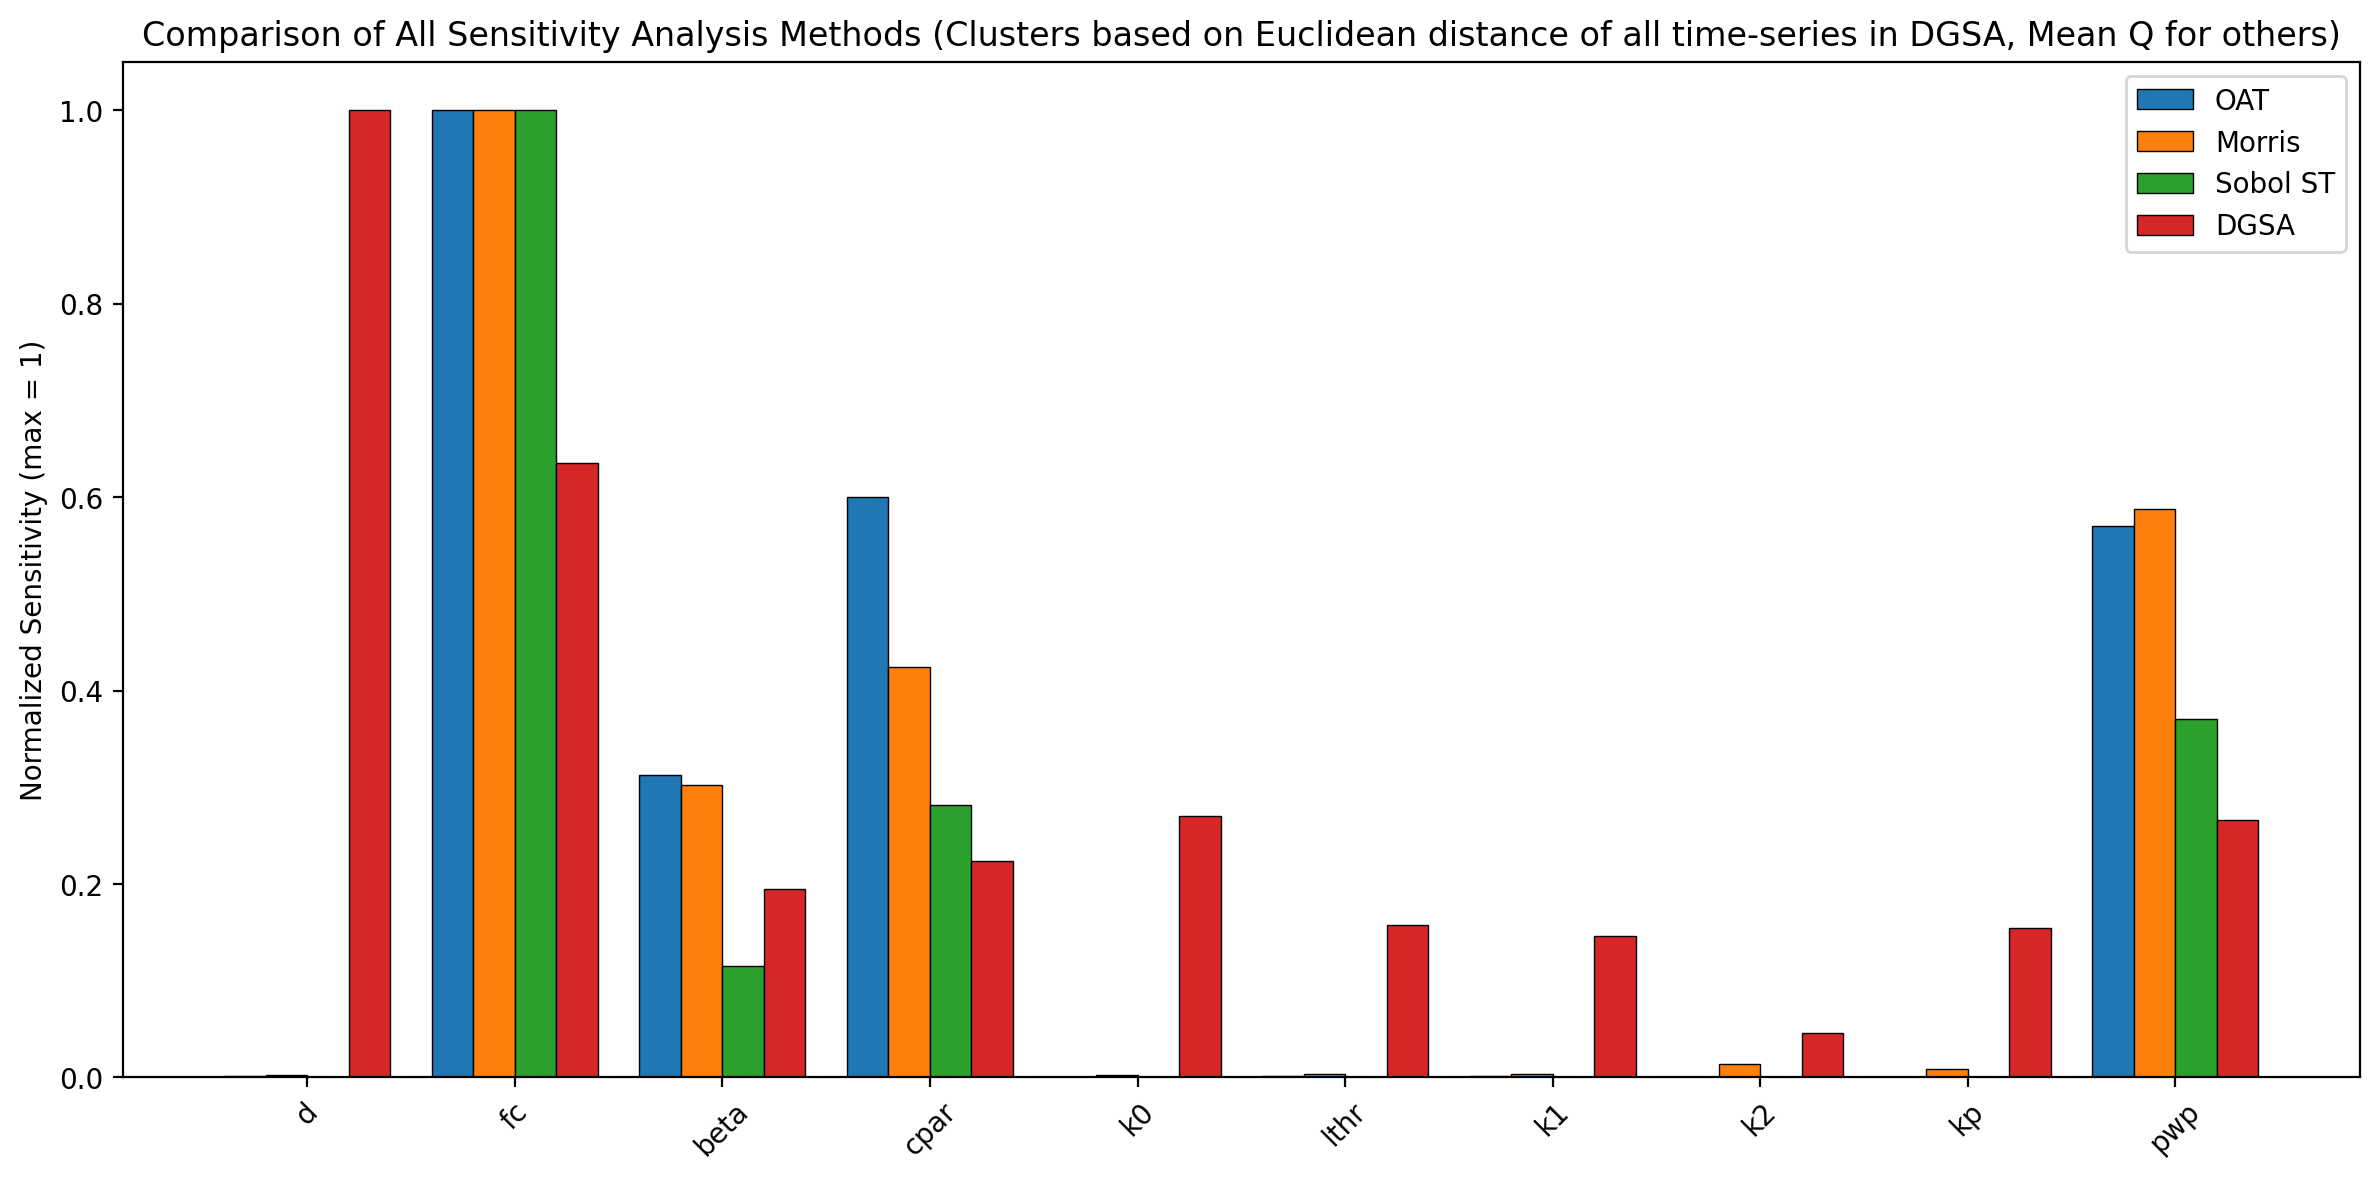

In [20]:
# Overall comparison including DGSA (using mean_Q for OAT/Morris/Sobol)
comparison = pd.DataFrame({
    'OAT': np.abs(oat_elasticities['mean_Q']),
    'Morris': Si_morris['mean_Q']['mu_star'],
    'Sobol ST': Si_sobol['mean_Q']['ST'],
    'DGSA': dgsa_main['sensitivity'].reindex(param_names).values,
}, index=param_names)

# Rankings
rankings = comparison.rank(ascending=False).astype(int)
print("Parameter Rankings (1 = most sensitive):")
print(rankings)

# Normalized grouped bar chart
comp_norm = comparison / comparison.max()
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(n_params)
width = 0.2
for j, (method, color) in enumerate(zip(comp_norm.columns, ['C0', 'C1', 'C2', 'C3'])):
    ax.bar(x + j*width - 1.5*width, comp_norm[method], width,
           label=method, color=color, edgecolor='k', linewidth=0.5)
ax.set_xticks(x)
ax.set_xticklabels(param_names, rotation=45)
ax.set_ylabel('Normalized Sensitivity (max = 1)')
ax.set_title('Comparison of All Sensitivity Analysis Methods (Clusters based on Euclidean distance of all time-series in DGSA, Mean Q for others)')
ax.legend()
plt.tight_layout()
plt.show()

## Summary

| Method | Type | Key Output | Interactions? | Multi-metric? |
|--------|------|------------|---------------|---------------|
| OAT | Local | Elasticity | No | Yes (per metric) |
| Morris | Global screening | $\mu^*$, $\sigma$ | Indirectly ($\sigma$) | Yes (per metric) |
| Sobol | Global variance-based | $S_1$, $S_{ij}$, $S_T$ | Yes ($S_{ij}$, $S_T - S_1$) | Yes (per metric) |
| DGSA | Global distribution-based | Sensitivity measure | Yes (explicit) | Multivariate natively |

**Key takeaways:**
- Sensitivity rankings can differ by flow metric (Mean Q vs Q10 vs Q90) — this highlights
  that different parameters control different aspects of the hydrograph.
- **OAT can be misleading for threshold parameters.** For example, OAT ranks `lthr` (upper
  reservoir threshold) as the 2nd most sensitive parameter for Mean Q, yet all three global
  methods (Morris, Sobol, DGSA) agree that `lthr` has negligible sensitivity. This happens
  because OAT only perturbs around the midpoint baseline — if that baseline sits near the
  threshold activation level, OAT detects a large local response that does not generalize
  across the full parameter space. This is a classic pitfall of local sensitivity analysis.
- Morris provides cost-effective screening to separate important from unimportant parameters.
- Sobol provides the most rigorous variance decomposition: $S_1$ for main effects,
  $S_{ij}$ for pairwise interactions, and $S_T$ for total effects including all orders.
- DGSA is distribution-based and non-parametric: it handles multivariate responses natively
  (e.g., full time series) and can explicitly quantify parameter interactions.